In [1]:
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd

C:\Users\AndreasLem\AppData\Local\pypoetry\Cache\virtualenvs\image-analysis--4Z0EFbM-py3.9\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the trained model 
model = torch.load('./backup/weights.pt')
# Set the model to evaluate mode
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [3]:
# Read the log file using pandas into a dataframe
df = pd.read_csv('./Experiment/log.csv')

### Training and testing loss, f1_score and auroc values for the model trained on the CrackForest dataset

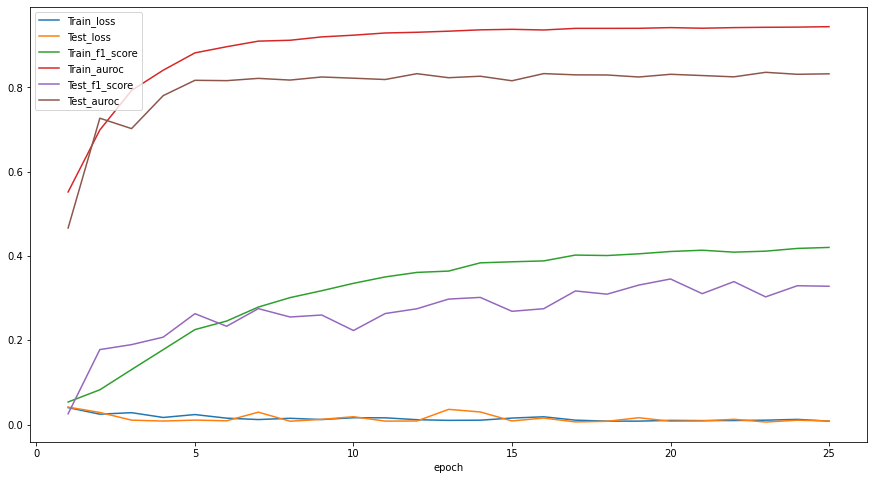

In [4]:
# Plot all the values with respect to the epochs
df.plot(x='epoch',figsize=(15,8));

In [5]:
print(df[['Train_auroc','Test_auroc']].max())

Train_auroc    0.943649
Test_auroc     0.835436
dtype: float64


### Sample Prediction

In [17]:
ino = 999
# Read  a sample image and mask from the data-set
img = cv2.imread(f'./CrackForest/Images/{ino:03d}.jpg').transpose(2,0,1).reshape(1,3,320,480)
mask = cv2.imread(f'./CrackForest/Masks/{ino:03d}_label.PNG')
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, torch.cuda.is_available())
    model.to(device)
    a = model(torch.from_numpy(img).type(torch.cuda.FloatTensor)/255)
    # a = model(torch.from_numpy(img).type(torch.FloatTensor)/255)

ValueError: cannot reshape array of size 613320 into shape (1,3,320,480)

(array([1.4400e+02, 7.8113e+04, 7.0941e+04, 2.0880e+03, 1.0880e+03,
        6.4100e+02, 3.4300e+02, 1.7100e+02, 6.0000e+01, 1.1000e+01]),
 array([-0.16188584, -0.08385921, -0.00583258,  0.07219405,  0.15022069,
         0.22824731,  0.30627397,  0.3843006 ,  0.4623272 ,  0.54035383,
         0.6183805 ], dtype=float32),
 <BarContainer object of 10 artists>)

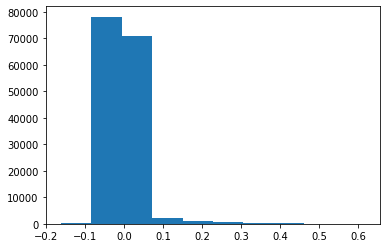

In [15]:
# Plot histogram of the prediction to find a suitable threshold. From the histogram a 0.1 looks like a good choice.
plt.hist(a['out'].data.cpu().numpy().flatten())

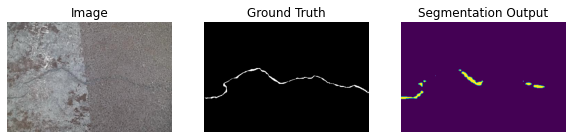

In [16]:
# Plot the input image, ground truth and the predicted output
plt.figure(figsize=(10,10));
plt.subplot(131);
plt.imshow(img[0,...].transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
plt.imshow(mask);
plt.title('Ground Truth')
plt.axis('off');
plt.subplot(133);
plt.imshow(a['out'].cpu().detach().numpy()[0][0]>0.2);
plt.title('Segmentation Output')
plt.axis('off');
plt.savefig('./CFExp/SegmentationOutput.png',bbox_inches='tight')